<a href="https://colab.research.google.com/github/saritmaitra/Sarit_Round2_Question2/blob/main/NLP_NER_CodeBasedApproach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@author: sarit maitra

In [ ]:
pip install ipython-autotime

## **Importing relevant libraries:**

In [2]:
%load_ext autotime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import re
import plac  #  wrapper over argparse
import random
import en_core_web_sm
import pprint
import string
string.punctuation
limit = 0
import subprocess
from string import punctuation
import unicodedata
import json, csv

from pandas import DataFrame, concat
from joblib import Parallel, delayed
from spacy import displacy
from collections import Counter
from pathlib import Path
from tqdm import tqdm  # loading bar
from IPython.display import display
from tqdm import tqdm 
from spacy.lang.en import STOP_WORDS
from tqdm import tqdm
from datetime import datetime
from bs4 import BeautifulSoup
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from itertools import groupby 
from collections import OrderedDict
from pathlib import Path
from sklearn.model_selection import train_test_split

from __future__ import unicode_literals, print_function


time: 898 ms (started: 2021-04-11 14:10:51 +00:00)


In [3]:
df = pd.read_csv('news_content.csv', sep=',',error_bad_lines=False)
df.head(1)

b'Skipping line 149: expected 6 fields, saw 7\nSkipping line 150: expected 6 fields, saw 7\nSkipping line 151: expected 6 fields, saw 7\nSkipping line 152: expected 6 fields, saw 7\nSkipping line 153: expected 6 fields, saw 7\nSkipping line 154: expected 6 fields, saw 7\nSkipping line 155: expected 6 fields, saw 7\nSkipping line 156: expected 6 fields, saw 7\nSkipping line 157: expected 6 fields, saw 7\nSkipping line 158: expected 6 fields, saw 7\nSkipping line 159: expected 6 fields, saw 7\nSkipping line 160: expected 6 fields, saw 7\nSkipping line 161: expected 6 fields, saw 7\nSkipping line 162: expected 6 fields, saw 7\nSkipping line 163: expected 6 fields, saw 7\nSkipping line 164: expected 6 fields, saw 7\nSkipping line 165: expected 6 fields, saw 7\nSkipping line 171: expected 6 fields, saw 7\nSkipping line 172: expected 6 fields, saw 7\nSkipping line 173: expected 6 fields, saw 7\nSkipping line 174: expected 6 fields, saw 7\nSkipping line 175: expected 6 fields, saw 7\nSkipping

,content,hyperlink,isFile,origin,timestamp,title
0,Cookies help us deliver our services. By using...,https://www.basf.com/sg/en/media/news-releases...,False,BASF,09 September 2020,BASF brings the farm to customers with launch ...


time: 213 ms (started: 2021-04-11 14:10:51 +00:00)


## **Visualization:**

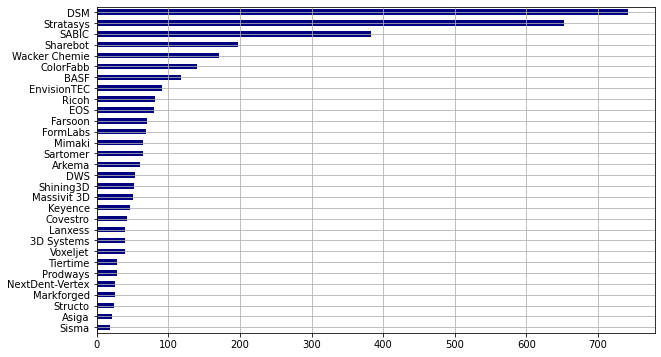

time: 397 ms (started: 2021-04-11 14:10:52 +00:00)


In [4]:
topics = df['origin'].value_counts().to_frame()[:30]
topics.sort_values(by='origin', ascending=True).plot(
    kind = 'barh', colormap='jet', legend=False, figsize=(10, 6));
plt.grid(True)

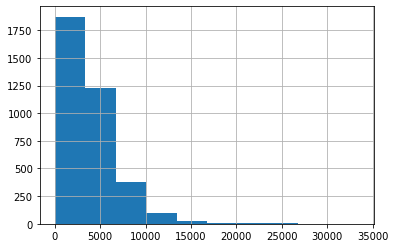

time: 236 ms (started: 2021-04-11 14:10:52 +00:00)


In [5]:
def plot_character_length_histogram(text):
    text.str.len().\
        hist()

plot_character_length_histogram(df['content'])

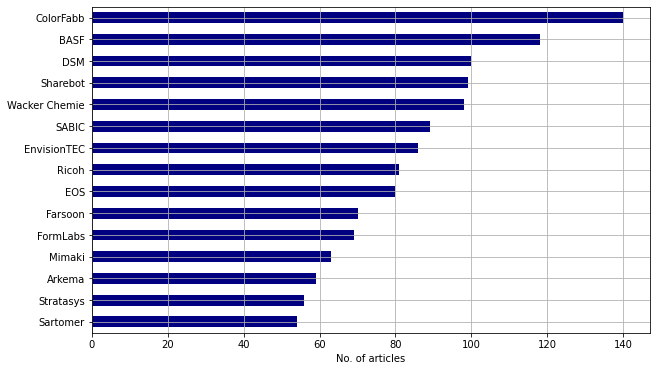

time: 351 ms (started: 2021-04-11 14:10:52 +00:00)


In [6]:
top_2000_topics =  df.loc[:2000, ('origin')].value_counts().to_frame()[:15]
top_2000_topics.sort_values(by='origin', ascending=True).plot(
    kind='barh', colormap='jet', legend=False, figsize=(10, 6));

plt.xlabel('No. of articles');
plt.grid(True)

## **Missing values:**

In [7]:
df.isnull().sum() # Checking null values

content      105
hyperlink      0
isFile         0
origin       111
timestamp      4
title          1
dtype: int64

time: 14.5 ms (started: 2021-04-11 14:10:53 +00:00)


In [8]:
df.dropna(inplace=True) # dropping all nan values
df.info()               # sanity check

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3504 entries, 0 to 3724
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    3504 non-null   object
 1   hyperlink  3504 non-null   object
 2   isFile     3504 non-null   bool  
 3   origin     3504 non-null   object
 4   timestamp  3504 non-null   object
 5   title      3504 non-null   object
dtypes: bool(1), object(5)
memory usage: 167.7+ KB
time: 35.8 ms (started: 2021-04-11 14:10:53 +00:00)


## **Distribution of articles in the dataset:**

In [9]:
print('The pre-processed data has {} news articles from {} unique topics'\
      .format(df.shape[0], df['content'].nunique()))

The pre-processed data has 3504 news articles from 3314 unique topics
time: 82.1 ms (started: 2021-04-11 14:10:53 +00:00)


## **Collecting relevant columns:**

In [10]:
df = df[['timestamp', 'title', 'hyperlink', 'content']]

# rename timestamp -> date_of_news
df.rename(columns = {'timestamp': 'date_of_news'}, inplace=True)
df.head(2) # sanity check

,date_of_news,title,hyperlink,content
0,09 September 2020,BASF brings the farm to customers with launch ...,https://www.basf.com/sg/en/media/news-releases...,Cookies help us deliver our services. By using...
1,14 August 2020,BASF enhances R&D capabilities with the acquis...,https://www.basf.com/sg/en/media/news-releases...,Cookies help us deliver our services. By using...


time: 29.9 ms (started: 2021-04-11 14:10:53 +00:00)


##**Converting to JSON**

In [11]:
inference = []
for (date_of_news, title, hyperlink, content), bag in df.groupby(['date_of_news', 'title', 'hyperlink', 'content']):
    contents_df = bag.drop(['date_of_news', 'title', 'hyperlink', 'content'], axis=1)
    subset = [OrderedDict(row) for i,row in contents_df.iterrows()]
    inference.append(OrderedDict([("date_of_news", date_of_news),
                                ("title", title),
                                ("hyperlink", hyperlink),
                                ('content', content)
                                ]))

print (json.dumps(inference[0], indent=4))

with open('news_content.json', 'w') as outfile:
   outfile.write(json.dumps(inference, indent=4))

{
    "date_of_news": "01 Apr 2010",
    "title": "Royal DSM N.V. Supervisory Board announcement",
    "hyperlink": "https://www.dsm.com/corporate/news/news-archive/2010/18-10-dsm-supervisory-board-announcement.html",
    "content": "Heerlen, NL, 01 Apr 2010 16:15 CEST Royal DSM N.V., the global Life Sciences and Materials Sciences company headquartered in the Netherlands, today announces that Mrs. Louise Gunning-Schepers will step down as member of the DSM Supervisory Board with effect from 1 September 2010 in connection with her appointment as president of the Health Council of the Netherlands, which was announced earlier today. Mrs. Gunning-Schepers (58, Dutch nationality) is currently Chairman of the Executive Board of the Academic Medical Center and Dean of the Medical Faculty of the University of Amsterdam. She is due to retire on 1 September 2010 and is expected to take up the post of president of the Health Council of the Netherlands with effect from that date. Mrs. Gunning-Sch

## **Train/Test split:**

In [12]:
trainD, testD = train_test_split(df, test_size=0.33, random_state=42)
print('Training data:', trainD.shape)
print('Test data:', testD.shape)

Training data: (2347, 4)
Test data: (1157, 4)
time: 18.4 ms (started: 2021-04-11 14:10:56 +00:00)


## **Load sPacy nlp model:**

 - nlp object contains processing pipeline
 - includes language-specific rulea for tokennization etc.

In [13]:
# creating nlp object
nlp = spacy.load('en')
print(nlp.pipe_names)

['tagger', 'parser', 'ner']
time: 857 ms (started: 2021-04-11 14:10:56 +00:00)


## **Test on raw data (training data):**

In [14]:
txt = str(trainD.content.values)
doc = nlp(txt)

entities = []
labels = []
position_start = []
position_end = []

for ent in doc.ents:
    entities.append(ent)
    labels.append(ent.label_)
    position_start.append(ent.start_char)
    position_end.append(ent.end_char)
    
df1 = DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})
print(df1)

                 Entities    Labels  Position_Start  Position_End
0                (Arkema)       ORG             130           136
1                    (3D)  CARDINAL             261           263
2          (Sumeet, Jain)    PERSON             789           800
3                (Arkema)       ORG             846           852
4                (Arkema)       ORG             855           861
..                    ...       ...             ...           ...
477             (Suzanne)    PERSON           29090         29097
478           (Mattaboni)    PERSON           29104         29113
479                 (610)  CARDINAL           29138         29141
480            (MakerBot)       ORG           29177         29185
481  (April, 15, ,, 2015)      DATE           29195         29209

[482 rows x 4 columns]
time: 1.08 s (started: 2021-04-11 14:10:56 +00:00)


In [15]:
person_entity = []
for ent in doc.ents:
    if ent.label_ == 'PERSON':
        person_entity.append(ent.text)
        
person_counts = Counter(person_entity).most_common()
df_person = DataFrame(person_counts, columns =['text', 'count'])
print(df_person)

                                                 text  count
0                                                BASF      2
1                                         Sumeet Jain      1
2                                            Sartomer      1
3       Prince Saud bin Abdullah bin Thenayan Al-Saud      1
4                                     Mohamed Al-Mady      1
5                                             Al-Mady      1
6   http://www.sabic.com/sustainability\xa0Samir A...      1
7                                               -0.16      1
8                                     Rudolf Staudigl      1
9                                    WACKER SILICONES      1
10                                WACKER BIOSOLUTIONS      1
11                                      Matthias Lang      1
12                                          Glysantin      1
13                                    Kaolin Minerals      1
14                                              BASFY      1
15                      

## **Let us clean the data to improve the model:**

### ***Text cleaner function:***
Objective is to extract relevant text using a regex.

I have defined a regex that parses only alphanumeric strings and hyphens (so as to include hyphenated words) that are between a given length (3 and 50). This filters each document down to only meaningful text for the lemmatizer.

In [16]:
def cleaner(df):
    pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
    df['clean'] = df['content'].str.findall(pattern).str.join(' ')
    if limit > 0:
        return df.iloc[:limit, :].copy()
    else:
        return df

pre_process = cleaner(df)
pre_process[['date_of_news', 'title', 'hyperlink', 'clean']].head(3)

,date_of_news,title,hyperlink,clean
0,09 September 2020,BASF brings the farm to customers with launch ...,https://www.basf.com/sg/en/media/news-releases...,Cookies help deliver our services using our se...
1,14 August 2020,BASF enhances R&D capabilities with the acquis...,https://www.basf.com/sg/en/media/news-releases...,Cookies help deliver our services using our se...
2,16 August 2020,Incident at BASF site in Gusan,https://www.basf.com/sg/en/media/news-releases...,Cookies help deliver our services using our se...


time: 583 ms (started: 2021-04-11 14:10:58 +00:00)


In [ ]:
txt = str(pre_process['clean'].values)
docx = nlp(txt)
for ent in docx.ents:
  # print([(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents])

  entities = []
  labels = []
  position_start = []
  position_end = []

for ent in docx.ents:
    entities.append(ent)
    labels.append(ent.label_)
    position_start.append(ent.start_char)
    position_end.append(ent.end_char)
    
df2 = DataFrame({'Labels':labels, 'Entities':entities,'Position_Start':position_start, 'Position_End':position_end})
print(df2)

### ***Removing stop words:***

In [19]:
# importing stop words from English language.
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Printing the total number of stop words:
print('Number of stop words: %d' % len(stopwords))

# Printing first ten stop words:
print('First ten stop words: %s' % list(stopwords)[:20])

Number of stop words: 326
First ten stop words: ['seemed', 'almost', 'somewhere', 'latterly', 'others', 'could', 'thru', 'everyone', 'an', 'below', 'whom', 'nobody', 'therefore', 'another', 'does', 'hence', 'nine', 'just', 'about', 'who']
time: 19.1 ms (started: 2021-04-11 14:11:23 +00:00)


### ***Sequentially process:***

In [20]:
def lemmatize(text):
    lemma_list = [str(tok.lemma_).lower() for tok in doc
              if tok.is_alpha and tok.text.lower() not in stopwords]
    return lemma_list

pre_process['preproc'] = pre_process['clean'].apply(lemmatize)
pre_process[['date_of_news', 'title', 'hyperlink', 'preproc']].head(3)

,date_of_news,title,hyperlink,preproc
0,09 September 2020,BASF brings the farm to customers with launch ...,https://www.basf.com/sg/en/media/news-releases...,"[able, access, private, document, video, priva..."
1,14 August 2020,BASF enhances R&D capabilities with the acquis...,https://www.basf.com/sg/en/media/news-releases...,"[able, access, private, document, video, priva..."
2,16 August 2020,Incident at BASF site in Gusan,https://www.basf.com/sg/en/media/news-releases...,"[able, access, private, document, video, priva..."


time: 18.7 s (started: 2021-04-11 14:11:23 +00:00)


#### ***Testing performance from above cleaning process:***

In [21]:
txt = str(pre_process['preproc'].values)
docx = nlp(txt)
for ent in docx.ents:
  # print([(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents])

  entities = []
  labels = []
  position_start = []
  position_end = []

for ent in docx.ents:
    entities.append(ent)
    labels.append(ent.label_)
    position_start.append(ent.start_char)
    position_end.append(ent.end_char)
    
df2 = DataFrame({'Labels':labels, 'Entities':entities,'Position_Start':position_start, 'Position_End':position_end})
print(df2)

     Labels      Entities  Position_Start  Position_End
0       LOC        (asia)             966           970
1      DATE  (', year, ')             973           979
2       GPE     (kepstan)            1220          1227
3    PERSON         (bin)            1993          1996
4    PERSON    (abdullah)            2000          2008
..      ...           ...             ...           ...
446     ORG         (sec)          155499        155502
447  PERSON       (johan)          155518        155523
448  PERSON     (suzanne)          155554        155561
449  PERSON   (mattaboni)          155565        155574
450    DATE       (april)          155630        155635

[451 rows x 4 columns]
time: 7.9 s (started: 2021-04-11 14:11:42 +00:00)


### ***nlp.pipe:***

Testing to check if cleaning process can be improved using nlp.pipe

 - I have followed sPacy documentation (https://spacy.io/api/language#pipe) for this.
 - As per documentation processing texts as a stream is usually more efficient than processing them one-by-one.

In [22]:
def lemmatize_pipe(doc):
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stopwords] 
    return lemma_list

def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

pre_process['preproc_pipe'] = preprocess_pipe(pre_process['clean'])
pre_process[['date_of_news', 'title', 'hyperlink', 'preproc_pipe']].head(3)

,date_of_news,title,hyperlink,preproc_pipe
0,09 September 2020,BASF brings the farm to customers with launch ...,https://www.basf.com/sg/en/media/news-releases...,"[cookie, help, deliver, service, service, agre..."
1,14 August 2020,BASF enhances R&D capabilities with the acquis...,https://www.basf.com/sg/en/media/news-releases...,"[cookie, help, deliver, service, service, agre..."
2,16 August 2020,Incident at BASF site in Gusan,https://www.basf.com/sg/en/media/news-releases...,"[cookie, help, deliver, service, service, agre..."


time: 3min 36s (started: 2021-04-11 14:11:50 +00:00)


#### ***Testing performance from above cleaning process:***

In [23]:
txt = str(pre_process['preproc_pipe'].values)
docx = nlp(txt)
for ent in docx.ents:
  # print([(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents])

  entities = []
  labels = []
  position_start = []
  position_end = []

for ent in docx.ents:
    entities.append(ent)
    labels.append(ent.label_)
    position_start.append(ent.start_char)
    position_end.append(ent.end_char)
    
df2 = DataFrame({'Labels':labels, 'Entities':entities,'Position_Start':position_start, 'Position_End':position_end})
print(df2)

      Labels      Entities  Position_Start  Position_End
0        GPE   (australia)             232           241
1        ORG        (basf)             327           331
2        ORG        (basf)             527           531
3       NORP  (australian)             535           545
4    PRODUCT      (canola)             568           574
..       ...           ...             ...           ...
172      GPE      (mexico)           35492         35498
173   PERSON       (erica)           35502         35507
174   PERSON       (erica)           35529         35534
175      GPE      (brazil)           35569         35575
176      ORG   (', ltd, ')           35673         35678

[177 rows x 4 columns]
time: 1.87 s (started: 2021-04-11 14:15:27 +00:00)


### ***Parallelize work:***

Testing with joblib.

 - sPacy recommends joblib library for processing blocks of NLP pipeline in parallel.

- Once joblib creates a set of worker processes that work on each chunk, each worker returns a "list of lists" containing lemmas for each document. These lists are then combined by the executor to provide a 3-level nested final "list of lists of lists".

- To ensure that the length of the output from the executor is the same as the actual number of articles, a "flatten" method is defined to combine the result into a list of lists containing lemmas.


In [24]:
def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(pre_process), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

pre_process['preproc_parallel'] = preprocess_parallel(pre_process['clean'], chunksize=1000)
pre_process[['date_of_news', 'title', 'hyperlink', 'preproc_parallel']].head(3)

,date_of_news,title,hyperlink,preproc_parallel
0,09 September 2020,BASF brings the farm to customers with launch ...,https://www.basf.com/sg/en/media/news-releases...,"[cookie, help, deliver, service, service, agre..."
1,14 August 2020,BASF enhances R&D capabilities with the acquis...,https://www.basf.com/sg/en/media/news-releases...,"[cookie, help, deliver, service, service, agre..."
2,16 August 2020,Incident at BASF site in Gusan,https://www.basf.com/sg/en/media/news-releases...,"[cookie, help, deliver, service, service, agre..."


time: 2min 49s (started: 2021-04-11 14:15:29 +00:00)


****Looking at processing time, parallilze work better performed than nlp.pipe. I have choosen to experiment with this one.****

In [25]:
# collecting relevant columns for my analysis
pre_process = pre_process[['date_of_news', 'title', 'hyperlink', 'preproc_parallel']].copy()

# renaming preproc_parallel -> article
pre_process.rename(columns = {'preproc_parallel': 'article'}, inplace=True)
pre_process.tail(2)

,date_of_news,title,hyperlink,article
3723,"May 17, 2016 3:27pm EDT",New FDM 3D Printer Enhancements Make Stratasys...,https://investors.stratasys.com/news-events/pr...,"[minneapolis, rehovot, business, wire, stratas..."
3724,"May 23, 2016 8:30am EDT",Stratasys to Showcase at SAMPE New 3D Printing...,https://investors.stratasys.com/news-events/pr...,"[minneapolis, rehovot, business, wire, stratas..."


time: 28.8 ms (started: 2021-04-11 14:18:18 +00:00)


In [26]:
pre_process['article'][:2] # sanity check

0    [cookie, help, deliver, service, service, agre...
1    [cookie, help, deliver, service, service, agre...
Name: article, dtype: object

time: 8.56 ms (started: 2021-04-11 14:18:18 +00:00)


## **Testing to check how nlp performs on clean data:**

Here, I have created a clean data set to analyze further and create a training set for sPacy.

In [29]:
txt = str(pre_process['article'].values)
docx = nlp(txt)
for ent in docx.ents:
  # print([(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents])

  entities = []
  labels = []
  position_start = []
  position_end = []

for ent in docx.ents:
    entities.append(ent)
    labels.append(ent.label_)
    position_start.append(ent.start_char)
    position_end.append(ent.end_char)
    
df2 = DataFrame({'Labels':labels, 'Entities':entities,'Position_Start':position_start, 'Position_End':position_end})
print(df2)

    # str(spacy.explain(ent.label_))

      Labels      Entities  Position_Start  Position_End
0        GPE   (australia)             232           241
1        ORG        (basf)             327           331
2        ORG        (basf)             527           531
3       NORP  (australian)             535           545
4    PRODUCT      (canola)             568           574
..       ...           ...             ...           ...
172      GPE      (mexico)           35492         35498
173   PERSON       (erica)           35502         35507
174   PERSON       (erica)           35529         35534
175      GPE      (brazil)           35569         35575
176      ORG   (', ltd, ')           35673         35678

[177 rows x 4 columns]
time: 1.86 s (started: 2021-04-11 14:19:20 +00:00)


In [30]:
# viewing in list format
print([(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents])

[('Arkema', 130, 136, 'ORG'), ('3D', 261, 263, 'CARDINAL'), ('Sumeet Jain', 789, 800, 'PERSON'), ('Arkema', 846, 852, 'ORG'), ('Arkema', 855, 861, 'ORG'), ('TCT Asia', 1043, 1051, 'ORG'), ('this year', 1052, 1061, 'DATE'), ('Arkema', 1064, 1070, 'ORG'), ('3D', 1133, 1135, 'CARDINAL'), ('Rilsan', 1196, 1202, 'ORG'), ('11', 1215, 1217, 'CARDINAL'), ('12', 1292, 1294, 'CARDINAL'), ('Kepstan', 1296, 1303, 'GPE'), ('Sartomer', 1386, 1394, 'PERSON'), ('Booth# E5-E71', 1507, 1520, 'ORG'), ('3d-arkema.com', 1557, 1570, 'CARDINAL'), ('2013', 1593, 1597, 'CARDINAL'), ('today', 1620, 1625, 'DATE'), ('Creating Lasting Value’', 1637, 1660, 'WORK_OF_ART'), ('Prince Saud bin Abdullah bin Thenayan Al-Saud', 2071, 2116, 'PERSON'), ('the Royal Commission for Jubail', 2130, 2161, 'ORG'), ('Yanbu', 2166, 2171, 'ORG'), ('SABIC', 2188, 2193, 'ORG'), ('third', 2213, 2218, 'ORDINAL'), ('Mohamed Al-Mady', 2652, 2667, 'PERSON'), ('SABIC', 2669, 2674, 'ORG'), ('SABIC', 2765, 2770, 'ORG'), ('\\xa0We', 2847, 2853,

In [31]:
df2[:1] # sanity check

,Labels,Entities,Position_Start,Position_End
0,GPE,(australia),232,241


time: 15.3 ms (started: 2021-04-11 14:20:02 +00:00)


### ***Tabular person_entitiy:***

In [32]:
person_entity = []
for ent in docx.ents:
    if ent.label_ == 'PERSON':
        person_entity.append(ent.text)
        
person_counts = Counter(person_entity).most_common()
df_person = DataFrame(person_counts, columns =['text', 'count'])
print(df_person)

        text  count
0    grabcad     10
1        joe      7
2    librett      6
3        lai      6
4        xie      6
5      erica      6
6     miguel      3
7        tim      2
8       phil      1
9       andy      1
10       kim      1
11      josh      1
12  autodesk      1
13      ryan      1
14      rick      1
time: 11.7 ms (started: 2021-04-11 14:20:17 +00:00)


In [33]:
# json string
df_person.to_json(orient='table', index=False)

'{"schema":{"fields":[{"name":"text","type":"string"},{"name":"count","type":"integer"}],"pandas_version":"0.20.0"},"data":[{"text":"grabcad","count":10},{"text":"joe","count":7},{"text":"librett","count":6},{"text":"lai","count":6},{"text":"xie","count":6},{"text":"erica","count":6},{"text":"miguel","count":3},{"text":"tim","count":2},{"text":"phil","count":1},{"text":"andy","count":1},{"text":"kim","count":1},{"text":"josh","count":1},{"text":"autodesk","count":1},{"text":"ryan","count":1},{"text":"rick","count":1}]}'

time: 9.68 ms (started: 2021-04-11 14:20:22 +00:00)


In [34]:
# number of times person appeared

xx = df_person.groupby('count')['text'].apply(list).to_dict()
print (xx)

{1: ['phil', 'andy', 'kim', 'josh', 'autodesk', 'ryan', 'rick'], 2: ['tim'], 3: ['miguel'], 6: ['librett', 'lai', 'xie', 'erica'], 7: ['joe'], 10: ['grabcad']}
time: 4.94 ms (started: 2021-04-11 14:20:55 +00:00)


### ***Tabular organizations_entity:***

In [35]:
organizations_entity = []
for ent in docx.ents:
    if ent.label_ == 'ORG':
        organizations_entity.append(ent.text)
        
organizations_counts = Counter(organizations_entity).most_common()
df_org = DataFrame(organizations_counts, columns = ['text', 'count'])
print(df_org)

    text  count
0  'ltd'      7
1    sec      6
2   basf      5
3    nsw      4
4   ssys      3
5    asa      2
time: 29.5 ms (started: 2021-04-11 14:26:36 +00:00)


In [36]:
# json string
df_org.to_json(orient='table', index=False)
print()
# number of times org appeared in news article
yy = df_org.groupby('count')['text'].apply(list).to_dict()
print (yy)


{2: ['asa'], 3: ['ssys'], 4: ['nsw'], 5: ['basf'], 6: ['sec'], 7: ["'ltd'"]}
time: 18.6 ms (started: 2021-04-11 14:26:41 +00:00)


***Now that I have tested, I need to create training data as per sPacy nlp format do can train a model and test on hold out testD (test data).***

In [37]:
pre_process.head(1)

,date_of_news,title,hyperlink,article
0,09 September 2020,BASF brings the farm to customers with launch ...,https://www.basf.com/sg/en/media/news-releases...,"[cookie, help, deliver, service, service, agre..."


time: 27.6 ms (started: 2021-04-11 14:27:02 +00:00)


## ***BELOW CODE BLOCK (TO GENERATE TRAINING SET) IS NOT TESTED YET***

In [38]:
article_groups = pre_process.groupby(by='date_of_news')
article_groups.get_group('09 September 2020')

,date_of_news,title,hyperlink,article
0,09 September 2020,BASF brings the farm to customers with launch ...,https://www.basf.com/sg/en/media/news-releases...,"[cookie, help, deliver, service, service, agre..."
158,09 September 2020,BASF brings the farm to customers with launch ...,https://www.basf.com/sg/en/media/news-releases...,"[cookie, help, deliver, service, service, agre..."


time: 64 ms (started: 2021-04-11 14:27:27 +00:00)


### ***Generating articles, word_tags from groups:***

In [ ]:
# def generate_data():
#   
#    articles = []
#    word_tags = []

#    for group_index, group in enumerate(article_groups):
#        key = float(group_index+1)
#        try:
#           article_df = article_groups.get_group(key)
#        except KeyError:
#            continue
#        article_words = article_df['articles'].values
#        article_word_tags = article_df['date_of_news', 'title', 'hyperlink'].values
#        article.append(sentence_words)
#        word_tags.append(article_word_tags)
      
#    return articles, word_tags
    


### ***Generating tag offsets for words of sentence:***

*****This is to transform sentences and assiciated entities into a format as required by sPacy nlp for model training. Here, I will train a CNNmodel.******

In [ ]:
# def generate_sentence_offsets_tuple(articles, tags):
#     
#     offsets = []
#     index = 0
#     articles_str = " ".join(articles)

#     for word, biluo_tag in zip(articles, tags):
#         if biluo_tag != 'O':            
#             offsets.append((index, index+len(word), biluo_tag))
#             #print(articles_str[index: index+len(word)])
#         #print(word, index, index+len(word), biluo_tag, articles_str[index: index+len(word)])
#         index = index+len(word)+1  
#     return (articles_str, {'entities': offsets})


In [ ]:
# def train(model, training_data, n_epochs=100):
#    if model is not None:
#       nlp = spacy.load(model)  # load existing spaCy model
#       print("Loaded model '%s'" % model)
#    else:
#       nlp = spacy.blank("en")  # create blank Language class
#       print("Created blank 'en' model")
#       # create the built-in pipeline components and add them to the pipeline
#       # nlp.create_pipe works for built-ins that are registered with spaCy
#    if "ner" not in nlp.pipe_names:
#       ner = nlp.create_pipe("ner")
#       nlp.add_pipe(ner, last=True)
#   # otherwise, get it so we can add labels
#    else:
#      ner = nlp.get_pipe("ner")

#      # add labels
#      for _, annotations in training_data:
#        for ent in annotations.get("entities"):
#          ner.add_label(ent[2])
 
#      # get names of other pipes to disable them during training
#      other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
   
#    with nlp.disable_pipes(*other_pipes):
#       # only train NER
#       # reset and initialize the weights randomly – but only if we're
#       # training a new model
#       if model is None:
#           nlp.begin_training()
#       for itn in range(n_epochs):
#         random.shuffle(training_data)
#         losses = {}
#         # batch up the examples using spaCy's minibatch
#         batches = minibatch(training_data, size=compounding(4.0, 32.0, 1.001))
#         for batch in batches:
#           texts, annotations = zip(*batch)
#           nlp.update(
#               texts,  # batch of texts
#               annotations,  # batch of annotations
#               drop=0.2,  # dropout - make it harder to memorise data
#               losses=losses,
#               )
#           print("epoch: {} Losses: {}".format(itn, str(losses)))
#    return nlp


In [ ]:

# def evaluate_model(pretrained_model, test_data):
#  
#   for test_instance in testD[4:10]:
#     test_sentence, entities = test_instance        
#     test_doc = pretrained_model(test_sentence)
#     predicted_entities = [(ent.text, ent.label_) for ent in test_doc.ents]        
#     original_entities = [(test_sentence[int(original_entity[0]): int(original_entity[1])], original_entity[2]) for original_entity in entities['entities']]
#     print("\n--->" + test_sentence)
#     print('predicted entities', predicted_entities)        
#     print('original entities', original_entities)
